# Setup

In [24]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [25]:
from sparse_field_lib import load_data

In [26]:
import matplotlib.pyplot as plt

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

In [27]:
sdss_dir = '/home/imendoza/bliss/data/sdss/'

# Load data

In [28]:
image, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/astropy/wcs/wcs.py:482: FITSFixedWarning: RADECSYS= 'ICRS ' / International Celestial Ref. System 
the RADECSYS keyword is deprecated, use RADESYSa.
  wcsprm = _wcs.Wcsprm(header=header_bytes, key=key,
/home/imendoza/.cache/pypoetry/virtualenvs/bliss-W0ocb7P7-py3.8/lib/python3.8/site-packages/astropy/wcs/wcs.py:706: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 51075.000000 from DATE-OBS.
Changed DATE-OBS from '19/09/98' to '1998-09-19''.
  warnings.warn(


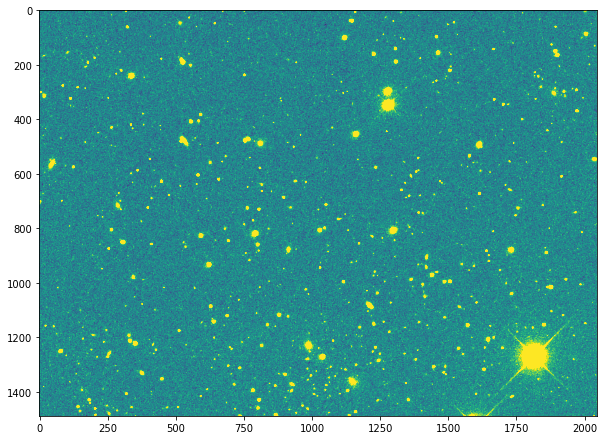

In [32]:
plt.figure(figsize=(10,10))
vmin = np.percentile(image.flatten(), 5)
vmax = np.percentile(image.flatten(), 95)

plt.imshow(image[0], vmin=vmin, vmax=vmax)